# **Importing Library**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from keras.models import load_model

# Functions

In [ ]:
def preProcess(img):
  imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgBlur = cv2.GaussianBlur(imgGray, (5,5),1)
  imgThreshold = cv2.adaptiveThreshold(imgBlur,255,1,1,11,2)
  return imgThreshold

def stackImages(imgArray,scale):
  rows = len(imgArray)
  cols = len(imgArray[0])
  rowAvailable = isinstance(imgArray[0],list)
  width = imgArray[0][0].shape[1]
  height = imgArray[0][0].shape[0]
  if rowAvailable:
    for x in range (0,rows):
      for y in range(0,cols):
        imgArray[x][y] = cv2.resize(imgArray[x][y],(0,0),None,scale,scale)
        if len(imgArray[x][y].shape) == 2:
          imgArray[x][y] = np.float32(imgArray[x][y])
          imgArray[x][y] = cv2.cvtColor(imgArray[x][y],cv2.COLOR_GRAY2BGR)
      imageBlank = np.zeros((height,width,3), np.uint8)
      hor = [imageBlank]*rows
      hor_con = [imageBlank]*rows
      for x in range(0,rows):
        hor[x] = np.hstack(imgArray[x])
        hor_con[x] = np.concatenate(imgArray[x])
      ver = np.vstack(hor)
      ver_con = np.concatenate(hor)
  else:
    for x in range(0,rows):
      imgArray[x] = cv2.resize(imgArray[x],(0,0),None,scale,scale)
      if len(imgArray[x].shape) == 2:
        imgArray[x] = cv2.cvtColor(imgArray[x][y],cv2.COLOR_GRAY2BGR)
    hor = np.hstack(imgArray)
    hor_con = np.concatenate(imgArray)
    ver = hor
  return ver

def biggestContour(contours):
  biggest = np.array([])
  max_area = 0
  for i in contours:
    area = cv2.contourArea(i)
    if area > 50:
      peri = cv2.arcLength(i,True)
      approx = cv2.approxPolyDP(i,0.02 * peri, True)
      if area > max_area and len(approx) == 4:
        biggest = approx
        max_area = area
  return biggest, max_area

def reorder(myPoints):
  myPoints = myPoints.reshape((4,2))
  myPointsNew = np.zeros((4,1,2),dtype=np.int32)
  add = myPoints.sum(1)
  myPointsNew[0] = myPoints[np.argmin(add)]
  myPointsNew[3] = myPoints[np.argmax(add)]
  diff = np.diff(myPoints, axis = 1)
  myPointsNew[1] = myPoints[np.argmin(diff)]
  myPointsNew[2] = myPoints[np.argmax(diff)]
  return myPointsNew

def splitBoxes(img):
  rows = np.vsplit(img,9)
  boxes = []
  for r in rows:
    cols = np.hsplit(r,9)
    for box in cols:
      boxes.append(box)
  return boxes

def intializePredectionModel():
  model = load_model('Digits.h5')
  return model

def getPredection(boxes,model):
  result = []

  img = np.asarray(boxes[5])
  img = img[4:img.shape[0]-4:, 4:img.shape[1]-4]
  img = cv2.resize(img,(32,32))
  img = img / 255
  img = img.reshape(1,32,32,1)
  predictions = model.predict(img)
  classIndex = np.argmax(predictions,axis=-1)
  probabilityValue = np.amax(predictions)
  print(classIndex,probabilityValue)

  for image in boxes:
    ## PREPARE IMAGE
    img = np.asarray(image)
    img = img[4:img.shape[0]-4:, 4:img.shape[1]-4]
    img = cv2.resize(img,(32,32))
    # img = cv2.resize(img,(28,28)) #1
    img = img / 255
    img = img.reshape(1,32,32,1)
    # img = img.reshape(1,28,28,1) #1
    ## GET PREDICTION
    predictions = model.predict(img)
    # classIndex = model.predict_classes(img)
    classIndex = np.argmax(predictions,axis=-1)
    probabilityValue = np.amax(predictions)
    # print(classIndex,probabilityValue)
    ## SAVE THE RESULT
    if probabilityValue > 0.8:
      result.append(classIndex[0])
    else:
      result.append(0)
  return result

def displayNumbers(img,numbers,color = (0,255,0)):
  secW = int(img.shape[1]/9)
  secH = int(img.shape[0]/9)
  for x in range (0,9):
    for y in range (0,9):
      if numbers[(y*9)+x] != 0:
        cv2.putText(img, str(numbers[(y*9)+x]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
  return img

def drawGrid(img):
  secW = int(img.shape[1]/9)
  secH = int(img.shape[0]/9)
  for i in range (0,9):
    pt1 = (0,secH*i)
    pt2 = (img.shape[1],secH*i)
    pt3 = (secW * i, 0)
    pt4 = (secW*i,img.shape[0])
    cv2.line(img, pt1, pt2, (255, 255, 0),2)
    cv2.line(img, pt3, pt4, (255, 255, 0),2)
  return img

# ***Sudoku Solver With Backtracking***

In [ ]:
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            if solve(bo):
                return True
            bo[row][col] = 0
    return False

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False
    return True

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")
        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")
            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col
    return None

# **Declare Global Variable**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# from IPython.display import Image
# try:
#   filename = take_photo()
#   print('Saved to {}'.format(filename))

#   # Show the image which was just taken.
#   display(Image(filename))
# except Exception as err:
#   # Errors will be thrown if the user does not have a webcam or if they do not
#   # grant the page permission to access it.
#   print(str(err))

In [ ]:
pathImage = 'sudoku1.jpg'
heightImg = 1008
widthImg = 1008
model = intializePredectionModel() # LOAD CNN MODEL

# **Step 1. Prepare the Image**

In [ ]:
img = cv2.imread(pathImage)
img = cv2.resize(img,(widthImg,heightImg)) # RESIZE IMAGE TO MAKE IT A SQUARE IMAGE
imgBlank = np.zeros((heightImg,widthImg,3),np.uint8) # CREATE A BLANK IMAGE FOR TESTING DEBUGING
imgThreshold = preProcess(img)

# **Step 2. Find All Contours**

In [ ]:
imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgContours,contours,-1,(0,255,0),3) # DRAW EXTERNAL DETECTED CONTOURS

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [250, 244, 245],
        [252, 246, 247],
        [252, 246, 247]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [253, 247, 248],
        [254, 249, 250],
        [254, 249, 250]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [253, 248, 249],
        [255, 250, 251],
        [255, 250, 251]]

# **Step 3. Find the biggest Contour and Use It as Sudoku**

In [ ]:
biggest, maxArea = biggestContour(contours) # FIND THE BIGGEST CONTOUR
if biggest.size != 0:
  biggest = reorder(biggest)
  cv2.drawContours(imgBigContour, biggest, -1, (0,0,255),20) # DRAW THE BIGGEST CONTOUR
  pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
  pts2 = np.float32([[0,0],[widthImg,0],[0,heightImg],[widthImg,heightImg]])
  matrix = cv2.getPerspectiveTransform(pts1,pts2)
  imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg,heightImg))
  imgDetectedDigits = imgBlank.copy()
  imgWarpColored = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)

# **Step 4. Split the Image and Find each digit available**

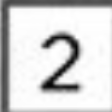

1/1 [==============================] - 0s 21ms/step
[1] 0.6385602
1/1 [==============================] - 0s 16ms/step
[2 1 0 0 6 0 9 0 0 0 0 0 0 0 9 1 0 0 4 0 9 3 1 0 0 5 8 0 0 1 0 0 5 0 4 0 9
 0 4 0 3 0 8 0 5 0 5 0 2 0 0 6 0 0 3 8 0 0 4 0 5 0 6 0 0 6 7 0 0 0 0 2 0 0
 2 0 8 0 3 0 0]


In [ ]:
imgSolvedDigits = imgBlank.copy()
boxes = splitBoxes(imgWarpColored)
cv2_imshow(boxes[0])
numbers = getPredection(boxes,model)

# print(numbers)
imgDetectedDigits = displayNumbers(imgDetectedDigits,numbers,color=(255,0,255))
numbers = np.asarray(numbers)
print(numbers)
posArray = np.where(numbers > 0,0,1)

# **Step 5. Solving Sudoku**

In [ ]:
board = np.array_split(numbers,9)
try:
  solve(board)
except:
  pass
flatList = []
for sublist in board:
  for item in sublist:
    flatList.append(item)
solvedNumbers = flatList*posArray
imgSolvedDigits = displayNumbers(imgSolvedDigits, solvedNumbers)

In [ ]:
print(solvedNumbers)

[0 0 5 4 0 8 0 3 7 7 3 8 5 2 0 0 6 4 0 6 0 0 0 7 2 0 0 6 2 0 8 9 0 7 0 3 0
 7 0 1 0 6 0 2 0 8 0 3 0 7 4 0 9 1 0 0 7 9 0 2 0 1 0 1 9 0 0 5 3 4 8 0 5 4
 0 6 0 1 0 7 9]


# **Step 6. Overlay Solution**

In [ ]:
pts2 = np.float32(biggest) # PREPARE POINTS FOR WARP
pts1 =  np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
matrix = cv2.getPerspectiveTransform(pts1, pts2)
imgInvWarpColored = img.copy()
imgInvWarpColored = cv2.warpPerspective(imgSolvedDigits, matrix, (widthImg, heightImg))
inv_perspective = cv2.addWeighted(imgInvWarpColored, 1, img, 0.5, 1)
imgDetectedDigits = drawGrid(imgDetectedDigits)
imgSolvedDigits = drawGrid(imgSolvedDigits)

# **Show Image**

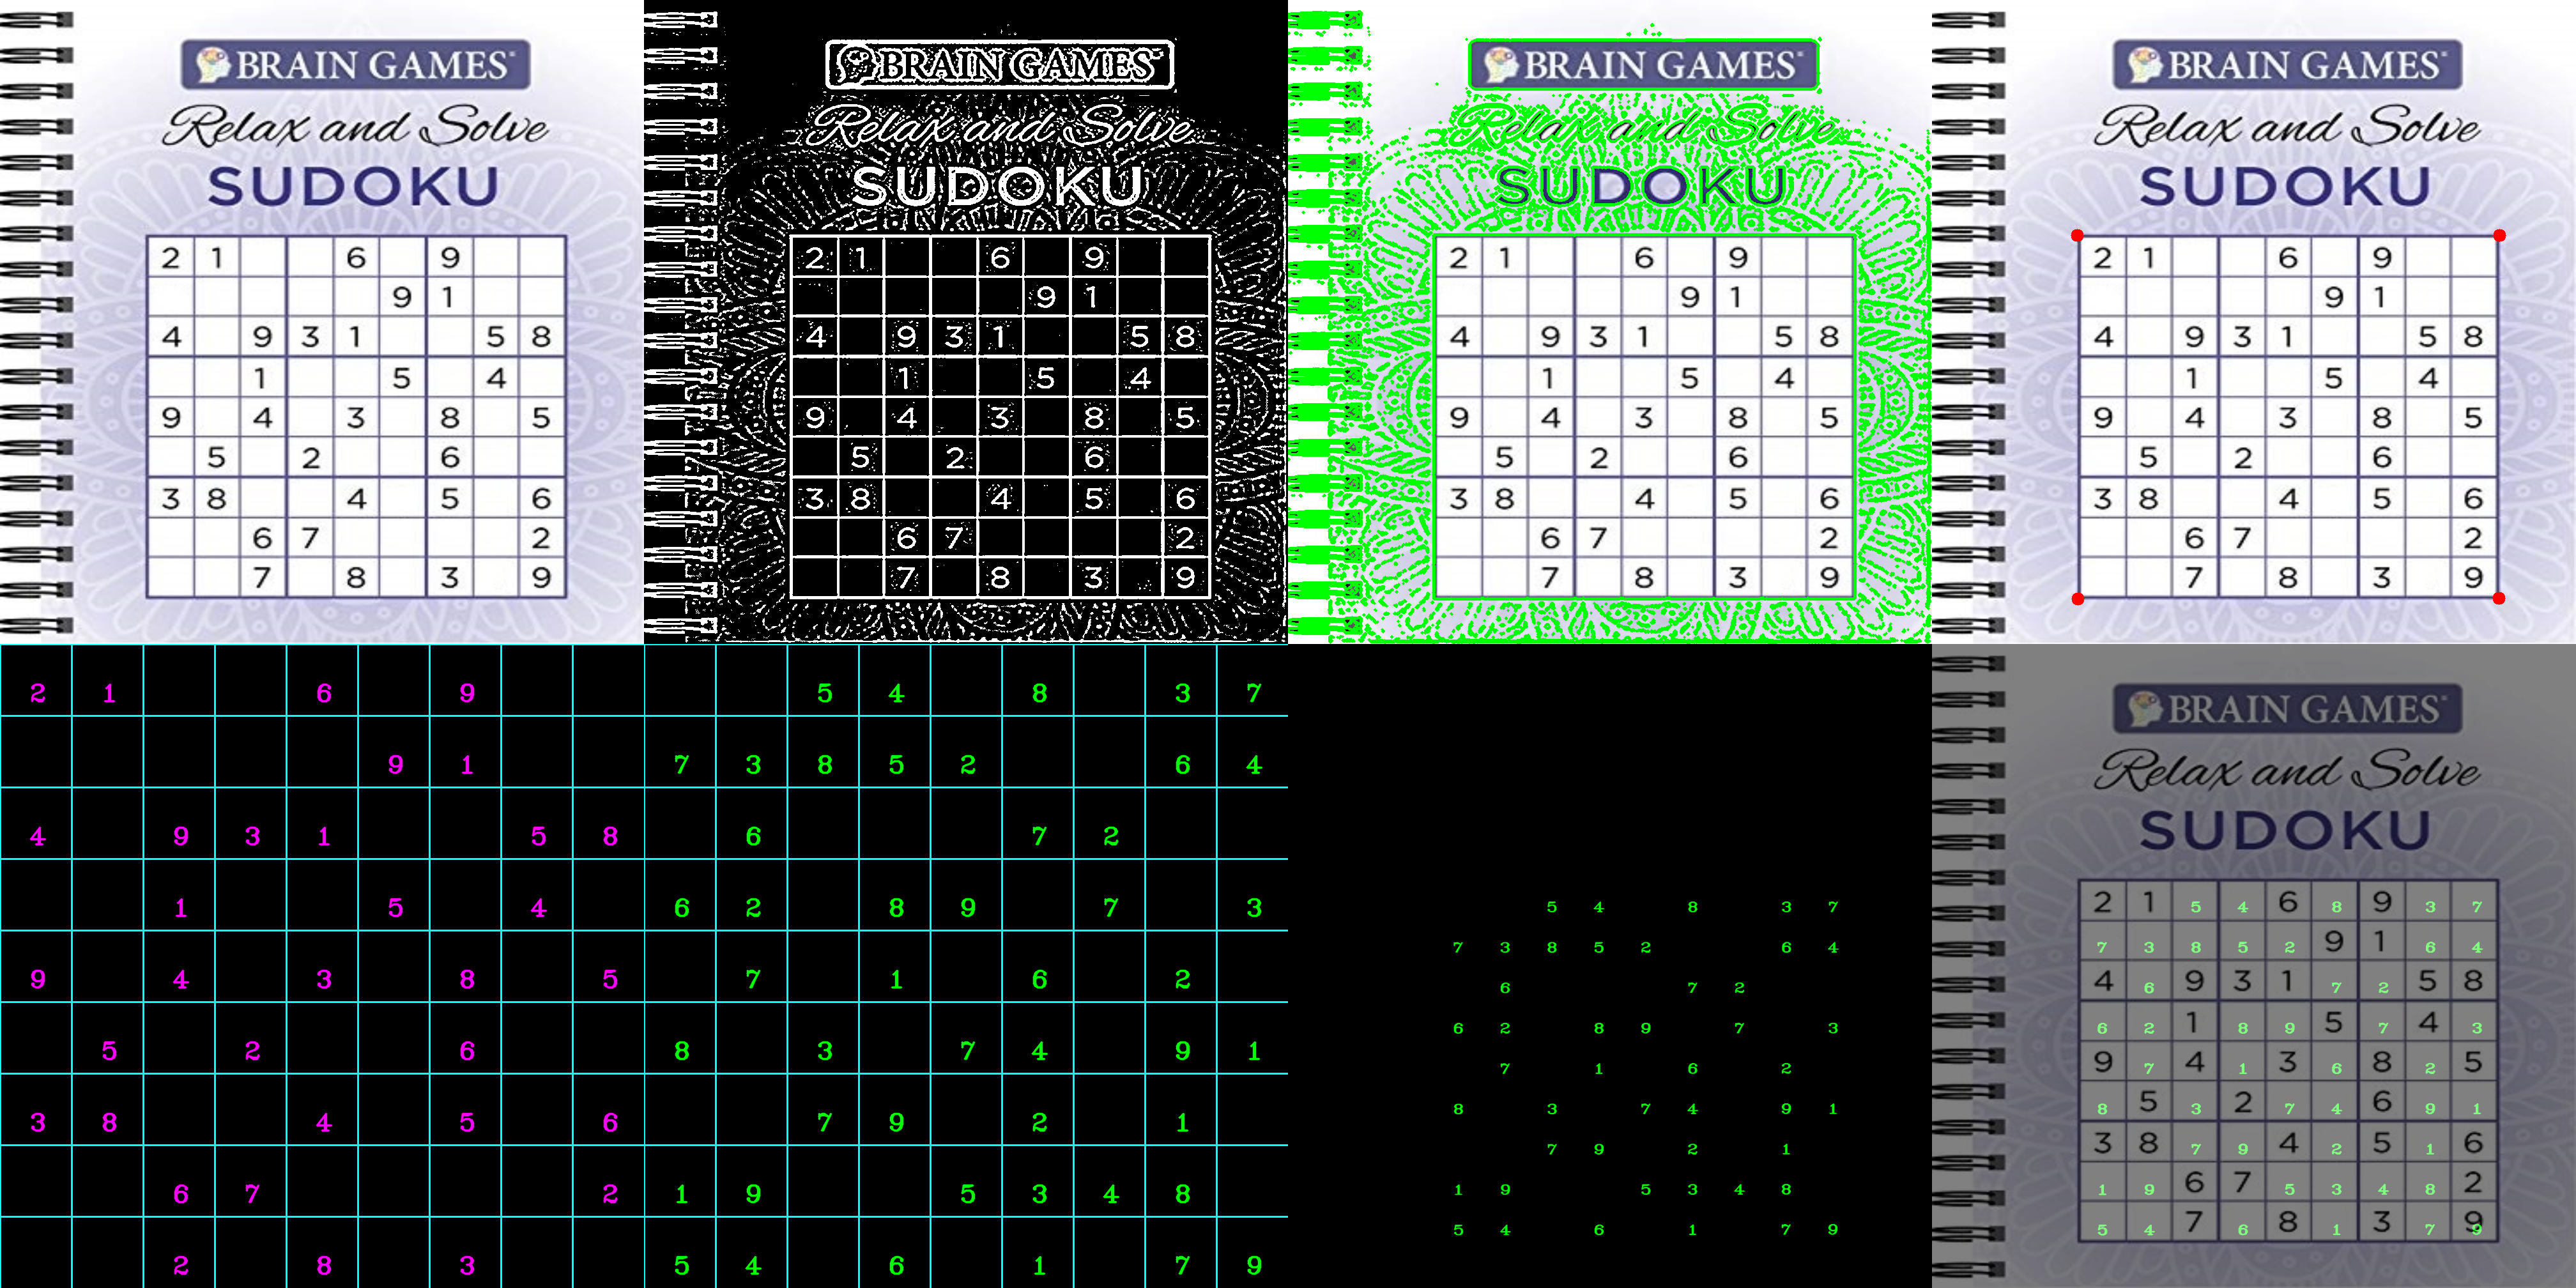

-1

In [ ]:
imageArray = ([img,imgThreshold,imgContours,imgBigContour],
              [imgDetectedDigits,imgSolvedDigits,imgInvWarpColored,inv_perspective])
stackedImage = stackImages(imageArray,1)
cv2_imshow(stackedImage)
cv2.waitKey(0)

In [ ]:
# cv2_imshow(img)
# cv2_imshow(imgThreshold)
# cv2_imshow(imgContours)
# cv2_imshow(imgBigContour)
# cv2_imshow(inv_perspective)